In [2]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax
import scipy.ndimage
import urllib.request

In [3]:
urllib.request.urlretrieve('https://www.dropbox.com/s/11rd44q5kdgdqki/kodim14.png?dl=1', filename='kodim14.png')

('kodim14.png', <http.client.HTTPMessage at 0x1ebfc556d90>)

In [4]:
# Our filters will be 50x50.
FILTER_SIZE = 50
x, y = np.meshgrid(np.linspace(-1, 1, FILTER_SIZE), np.linspace(-1, 1, FILTER_SIZE))

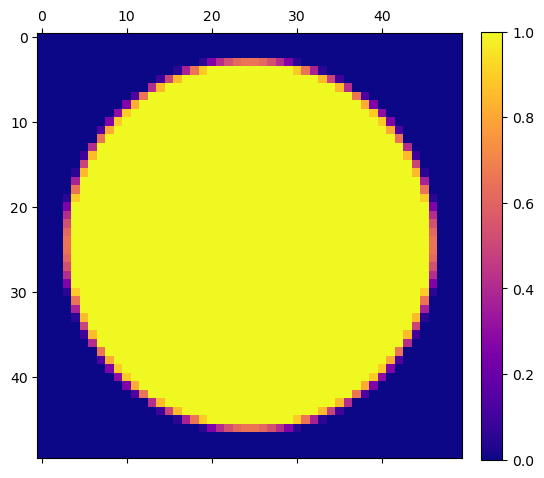

In [36]:
# Simple circular filter with basic anti-aliasing.
circle = np.array(np.clip((0.825 - (x*x + y*y)) * 12.0, 0.0, 1.0), dtype='float64')

# Show the shape.
plt.rcParams["figure.figsize"] = (6, 6)
plt.matshow(circle, cmap='plasma')
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

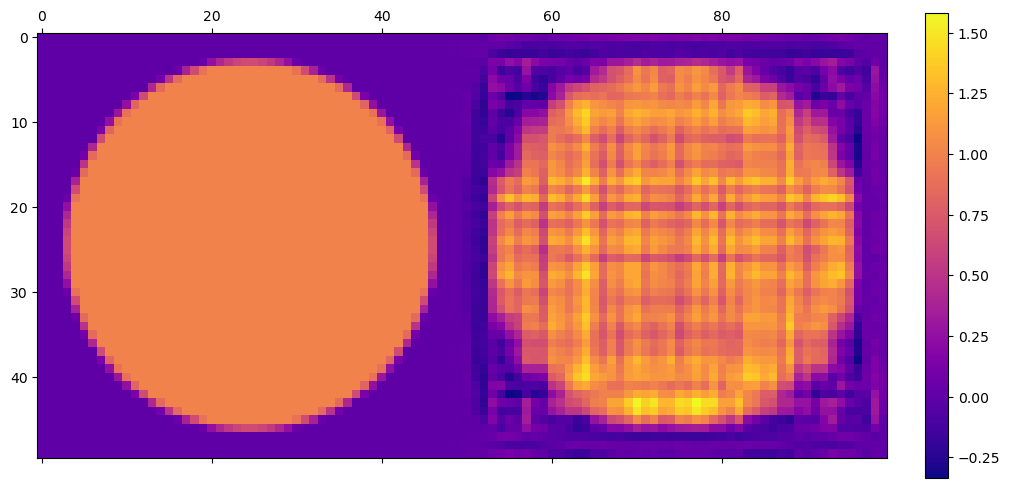

In [72]:
# Returns SVD-based low rank approximation of the matrix m.
def low_rank_approx(m, rank = 1):
  U,E,V = np.linalg.svd(m)
  mn = np.zeros_like(m)
  vs = []
  for i in range(rank):
    # We collect the U and V vectors and distribute the singular value uniformly in both of them.
    Fx = U[:,i] * np.sqrt(E[i])
    Fy = V[i,:] * np.sqrt(E[i])
    #add random noise to the filter
    Fx = Fx + np.random.normal(0, 0.1, Fx.shape)
    Fy = Fy + np.random.normal(0, 0.1, Fy.shape)
    vs.append(0.5*(Fx + Fy))
    mn += np.outer(Fx, Fy)
  return mn, vs

# Show an example low rank approximation.
plt.rcParams["figure.figsize"] = (6, 6)
plt.matshow(np.hstack((circle, low_rank_approx(circle, 4)[0])), cmap='plasma')
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

In [384]:
REF_SHAPE = multistep_jacobi
#REF_SHAPE = matrix
#normalize the shape
#REF_SHAPE = REF_SHAPE / np.max(REF_SHAPE)
FILTER_SIZE = REF_SHAPE.shape[0]
RANK = 8

def get_random_filter():
  # We sample a random filter from a normal distribution.
  F = np.random.normal(1.0, 1.0, FILTER_SIZE)
  # We normalize the filter to have unit L2 norm.
  F = F / np.sqrt(np.sum(F * F))
  return F

def get_random_separable_filters():
  f = []
  for n in range(RANK):
    f.append(get_random_filter())
  return f

# We just sum the outer tensor products.
# vs is a list of tuples - pairs of separable horizontal and vertical filters.
def model(vs):
  res = jnp.zeros((FILTER_SIZE, FILTER_SIZE))
  for n in range(RANK):
    res += jnp.outer(vs[n], vs[n])
  return res

  for n in range(RANK2):
    ReX = vs[2*n][0]
    ReY = vs[2*n][1]
    ImX = vs[2*n+1][0]
    ImY = vs[2*n+1][1]
    dstRe += jnp.outer(ReX, ReY) - jnp.outer(ImX, ImY)
    dstIm += jnp.outer(ReX, ImY) + jnp.outer(ImX, ReY)
  return dstIm*dstIm + dstRe*dstRe

# Our loss function. 
def loss(vs, l2_weight = 1.0, non_negativity_weight = 2.0, keep_zeros_weight = 0.1):
  mdld = model(vs)
  l2_term = l2_weight * jnp.mean(jnp.square(mdld - REF_SHAPE))
  non_negative_term = non_negativity_weight * jnp.mean(-jnp.minimum(mdld, 0.0))
  keep_zeros_term = keep_zeros_weight * np.mean((REF_SHAPE == 0.0) * jnp.abs(mdld))
  return l2_term + non_negative_term + keep_zeros_term 

# We perform a single iteration of gradient descent. Jit it for way better performance.
@jax.jit
def update_parameters_step(vs, learning_rate = 1.0, l2_weight = 1.0, non_negativity_weight = 2.0, keep_zeros_weight = 0.1):
  grad_loss = jax.grad(loss)
  grads = grad_loss(vs, l2_weight, non_negativity_weight, keep_zeros_weight)
  return [(param - learning_rate * grad) for param, grad in zip(vs, grads)]

# Our whole optimization loop.
def optimize_loop(vs, l2_weight = 1.0, non_negativity_weight = 2.0, keep_zeros_weight = 0.1, print_loss = False, learning_rate = 1.0, iterations = 20000, learning_rate_decay = 0.75, learning_rate_increase = 1.05, max_learning_rate = 150.0):
  NUM_STEPS = iterations
  prev_loss = 1e10
  for n in range(NUM_STEPS+1):
    vs = update_parameters_step(vs, l2_weight=l2_weight, non_negativity_weight=non_negativity_weight, keep_zeros_weight=keep_zeros_weight, learning_rate=learning_rate)
    if print_loss and n % 100 == 0:
      # We print the loss every 1000 steps.
      cur_loss = loss(vs)
      print(f'Loss at step {n}: {cur_loss:.4e}, learning rate: {learning_rate:.4e}')
      if(cur_loss > prev_loss):
        learning_rate *= learning_rate_decay #if the loss is increasing, we reduce the learning rate
      elif(learning_rate < max_learning_rate):
        learning_rate *= learning_rate_increase #if the loss is decreasing, we increase the learning rate
      prev_loss = cur_loss
  return vs

In [385]:

vs = get_random_separable_filters()
#vs = low_rank_approx(REF_SHAPE, RANK)[1]
vs = optimize_loop(vs, non_negativity_weight=0.0, keep_zeros_weight=0.0, print_loss=True, learning_rate=5.0, iterations=10000, learning_rate_decay=1.0, learning_rate_increase=1.0, max_learning_rate=150.0)
result_filter = model(vs)

Loss at step 0: 7.9664e-03, learning rate: 5.0000e+00
Loss at step 100: 1.5105e-03, learning rate: 5.0000e+00
Loss at step 200: 1.0134e-03, learning rate: 5.0000e+00
Loss at step 300: 1.1249e-03, learning rate: 5.0000e+00
Loss at step 400: 1.0762e-03, learning rate: 5.0000e+00
Loss at step 500: 9.8713e-04, learning rate: 5.0000e+00
Loss at step 600: 9.0314e-04, learning rate: 5.0000e+00
Loss at step 700: 8.3133e-04, learning rate: 5.0000e+00
Loss at step 800: 7.6991e-04, learning rate: 5.0000e+00
Loss at step 900: 7.1578e-04, learning rate: 5.0000e+00
Loss at step 1000: 6.6764e-04, learning rate: 5.0000e+00
Loss at step 1100: 6.2310e-04, learning rate: 5.0000e+00
Loss at step 1200: 5.8147e-04, learning rate: 5.0000e+00
Loss at step 1300: 5.4206e-04, learning rate: 5.0000e+00
Loss at step 1400: 5.0504e-04, learning rate: 5.0000e+00
Loss at step 1500: 4.7030e-04, learning rate: 5.0000e+00
Loss at step 1600: 4.3858e-04, learning rate: 5.0000e+00
Loss at step 1700: 4.0980e-04, learning rat

In [386]:
vs = optimize_loop(vs, non_negativity_weight=0.0, keep_zeros_weight=0.0, print_loss=True, learning_rate=2, max_learning_rate=500)
result_filter = model(vs)

Loss at step 0: 9.6359e-05, learning rate: 2.0000e+00
Loss at step 100: 9.6145e-05, learning rate: 2.1000e+00
Loss at step 200: 9.5923e-05, learning rate: 2.2050e+00
Loss at step 300: 9.5692e-05, learning rate: 2.3153e+00
Loss at step 400: 9.5451e-05, learning rate: 2.4310e+00
Loss at step 500: 9.5202e-05, learning rate: 2.5526e+00
Loss at step 600: 9.4944e-05, learning rate: 2.6802e+00
Loss at step 700: 9.4677e-05, learning rate: 2.8142e+00
Loss at step 800: 9.4399e-05, learning rate: 2.9549e+00
Loss at step 900: 9.4112e-05, learning rate: 3.1027e+00
Loss at step 1000: 9.3813e-05, learning rate: 3.2578e+00
Loss at step 1100: 9.3504e-05, learning rate: 3.4207e+00
Loss at step 1200: 9.3183e-05, learning rate: 3.5917e+00
Loss at step 1300: 9.2852e-05, learning rate: 3.7713e+00
Loss at step 1400: 9.2516e-05, learning rate: 3.9599e+00
Loss at step 1500: 9.2171e-05, learning rate: 4.1579e+00
Loss at step 1600: 9.1817e-05, learning rate: 4.3657e+00
Loss at step 1700: 9.1452e-05, learning rat

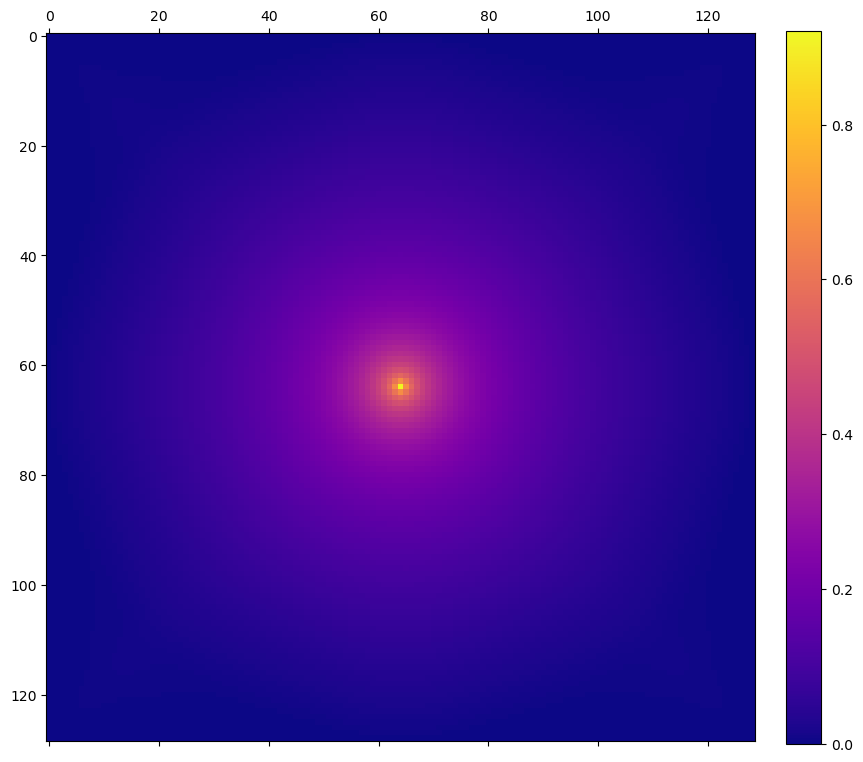

In [387]:
#plot the resulting filter
plt.rcParams["figure.figsize"] = (10, 10)

plt.matshow(result_filter, cmap='plasma')
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()


In [392]:
#write the filter to a glsl file
def write_as_glsl(vs, filename):
    
    num_ranks = len(vs)//2
    N = len(vs[0])
    Nc = N//2

    with open(filename, "w") as f:
        f.write("//The filter: \n")

        f.write("const vec2 K[{}] = vec2 [](".format(N * num_ranks))
        array = ""
        for i in range(num_ranks):
            for j in range(N):
                array += "vec2({:.4e}, {:.4e}) ".format(vs[2*i][j], vs[2*i+1][j])
                if(i != num_ranks-1 or j != N-1):
                    array += ", "
        f.write(array)
        f.write(");\n")
        f.write("//center of the convolution \n")
        f.write("const int Nc = {}; \n".format(Nc))
        f.write("//number of ranks \n")
        f.write("const int Nr = {}; \n".format(num_ranks))
        f.write("//convolution size \n")
        f.write("const int N = {}; \n".format(N))
     
 

In [393]:
write_as_glsl(vs, "kernels.glsl")

In [269]:
#print list length
print(len(vs1))

8


0.25000000000000006
0.24999999999999994
0.25
0.24999999999999994
0.24999999999987246
0.24999999998586875
0.24999999961989508
0.2499999956477313
0.2499999714588084
0.24999987260562612
0.24999956898348402
0.2499988136323064
0.2499972115129296
0.24999420767061406
0.24998909711520514
0.24998105279564664
0.24996916501443942
0.2499524852639555
0.24993006872007603
0.249901011489056
0.2498644805095296
0.24981973544723848
0.24976614290561558
0.24970318385636936
0.2496304554640332
0.24954766853499266
0.24945464174718754
0.24935129367325848
0.2492376334393183
0.2491137506902015
0.2489798053746693
0.2488360177277071
0.24868265871393525
0.24852004110531783
0.24834851129571325
0.2481684419013276
0.24798022515695473
0.2477842670900691
0.2475809824360639
0.24737079024600253
0.24715411013154354
0.24693135908873654
0.2467029488421639
0.246469283652588
0.24623075853409743
0.2459877578304242
0.24574065410411408
0.24548980729643882
0.24523556412013384
0.24497825765099204
0.24471820708823125
0.2444557176570

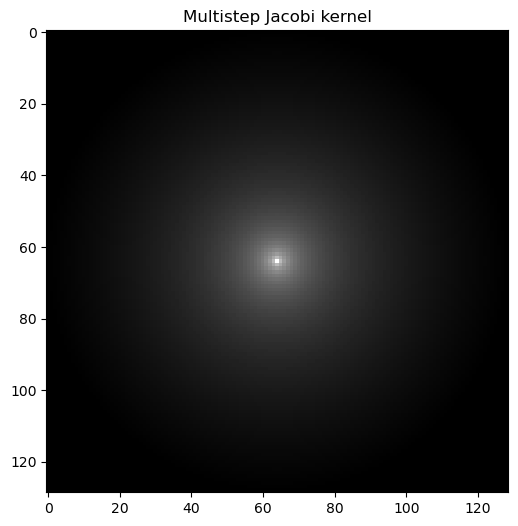

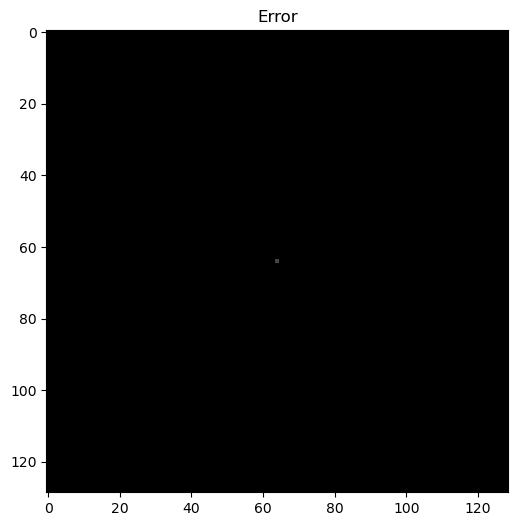

0.00017405987658427376
0.21218075840227194
0.0011319660302496859


In [218]:
# multistep poisson equation kernel
multistep_jacobi = np.zeros((129, 129))

average_kernel = np.array([[0, 0.25, 0], [0.25, 0, 0.25], [0, 0.25, 0]])

#get the size of the array
new_size = multistep_jacobi.shape[0]

center = new_size // 2

#do a red black gauss seidel iteration using numpy    
#array of coordinates
xcoord = np.arange(new_size)
ycoord = np.arange(new_size)

coordsx, coordsy = np.meshgrid(xcoord, ycoord)

#array of red and black coordinates
red = (coordsx + coordsy) % 2 == 0
black = 1 - red

dist_to_center = np.sqrt((coordsx - center)**2 + (coordsy - center)**2)

#boundary mask at distance new_size/2
#boundary_mask = dist_to_center < new_size / 2

#just use a square boundary mask
boundary_mask = np.ones((new_size, new_size))
boundary_mask[0, :] = 0
boundary_mask[-1, :] = 0
boundary_mask[:, 0] = 0
boundary_mask[:, -1] = 0

def averageFilter(array):
    #use scipy convolve2d to average the array
    import scipy.signal
    return scipy.signal.convolve2d(array, average_kernel, mode='same')
    

#solve the possion equation for a delta function source at the center for 1 step
def poissonConv(a):
    a = averageFilter(a)

    #add the source
    a[center, center] += 0.25

    #zero border conditions
    a = a * boundary_mask

    return a


# check the error of the poisson equation
def poissonError(a):
    #get the size of the array
    new_size = a.shape[0]

    center = new_size // 2
    error = averageFilter(a) - a.copy()

    #add the source
    error[center, center] += 0.25

    #zero border conditions
    a = a * boundary_mask

    return np.abs(error)

# convolve the multistep kernel with the poisson kernel N times
for i in range(1500):
    for j in range(32):
        multistep_jacobi = poissonConv(multistep_jacobi)
    error = poissonError(multistep_jacobi)
    print(np.sum(error))

# plot the result
plt.imshow(multistep_jacobi, cmap="gray")
plt.title("Multistep Jacobi kernel")
plt.clim(np.min(multistep_jacobi), np.max(multistep_jacobi))
plt.show()

# plot the error
error = poissonError(multistep_jacobi)
plt.imshow(poissonError(error), cmap="gray")
plt.title("Error")
#use the same color scale as the multistep kernel
plt.clim(np.min(multistep_jacobi), np.max(multistep_jacobi))
plt.show()

print(np.sum(error**2))
print(np.sum(error))
#print max error
print(np.max(error))

In [183]:
# load png image as numpy matrix at given user path
def load_image(path):
    from PIL import Image
    img = Image.open(path)
    img.load()
    data = np.asarray(img, dtype="float32")
    return data
    

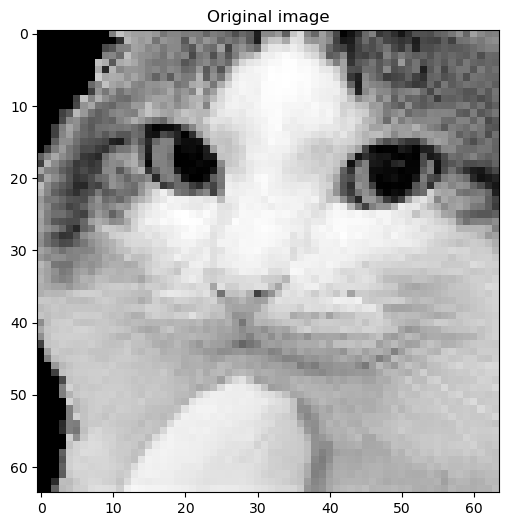

In [184]:
matrix = img = load_image("D:/catthink.png") 
matrix = matrix[:,:,0]

# plot the image
plt.imshow(matrix, cmap="gray")
plt.title("Original image")
plt.show()


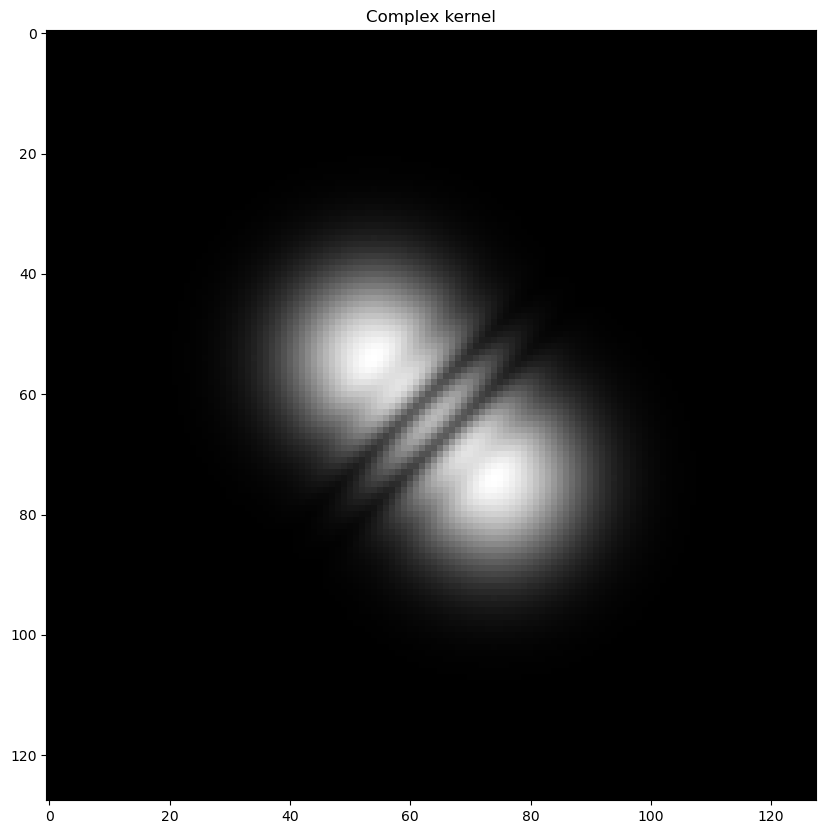

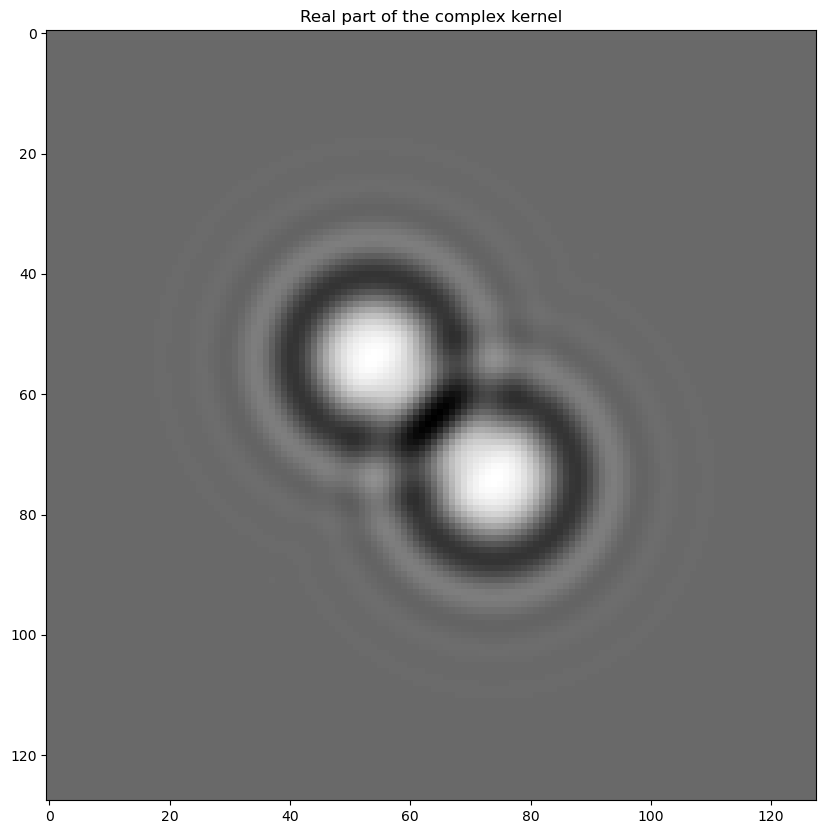

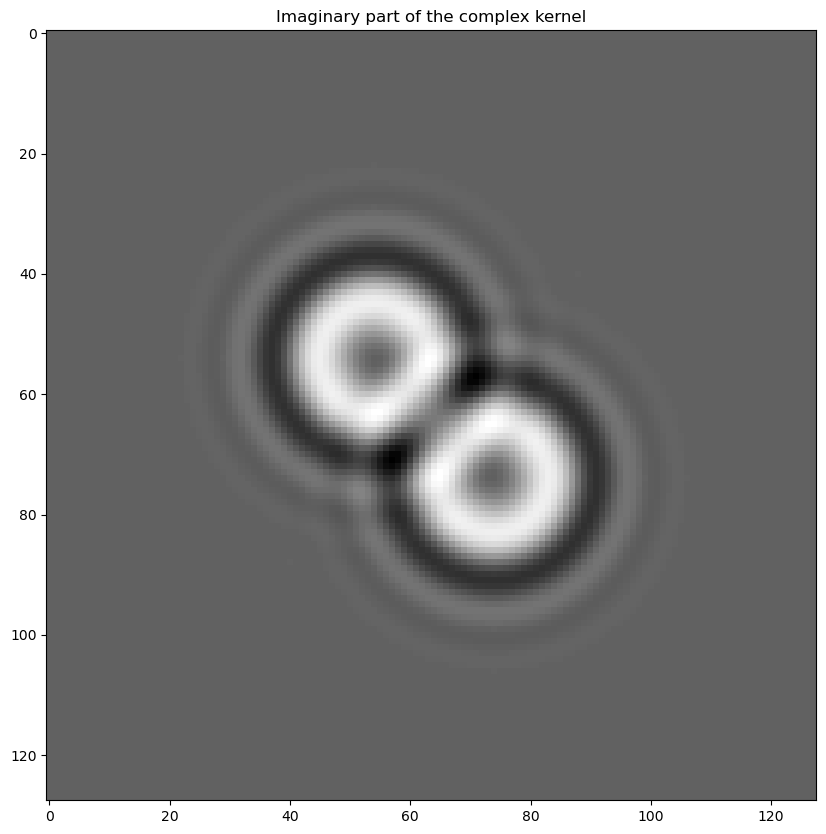

In [306]:
N = 128

#create an array with 2 complex valued gaussian kernels added together
def gaussian_kernel(N, C, sigma):
    x = np.arange(N)
    y = np.arange(N)
    coordsx, coordsy = np.meshgrid(x, y)
    center = N // 2
    R = (coordsx - C[0])**2 + (coordsy - C[1])**2
    #complex coefficient
    aRe = 1.0
    aIm = -3.0
    a = aRe + 1j * aIm
    return np.exp(- a * R / (2 * sigma**2))

#add the two kernels
kernel = gaussian_kernel(N, (N//2+10, N//2+10), 10) + gaussian_kernel(N, (N//2-10, N//2-10), 10)

#plot the complex kernel
plt.imshow(np.abs(kernel), cmap="gray")
plt.title("Complex kernel")
plt.show()

#plot the real part of the complex kernel
plt.imshow(kernel.real, cmap="gray")
plt.title("Real part of the complex kernel")
plt.show()

#plot the imaginary part of the complex kernel
plt.imshow(kernel.imag, cmap="gray")
plt.title("Imaginary part of the complex kernel")
plt.show()

